In [1]:
import cupy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy
import h5py
from PIL import Image
import numpy as np
import time

from skimage.morphology import binary_dilation
from scipy.optimize import minimize

from scipy import ndimage
from scipy import interpolate

from skimage.morphology import skeletonize, opening, closing, erosion, dilation, disk
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.morphology import convex_hull_image
from skimage.restoration import inpaint
from skimage import feature

from scipy.ndimage import gaussian_filter

/ibira/lnls/labs/tepui/apps/modules/python/3.9.2/lib/python3.9/site-packages/cupy/_environment.py:436: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda110, cupy-cuda112

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


## GPU info

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 29 16:16:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:0F:00.0 Off |                    0 |
| N/A   24C    P0    52W / 400W |     24MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:47:00.0 Off |                    0 |
| N/A   

## Image Vizualization

In [3]:
def imshow(img, size, savename=None, show=False):

    """ Function to display a given image, segmenting colours wrt to a log-scale.

    Args:
        img: (ndarray) image
        size: tuple indicating the aspect ratio
        savename: path to save the image (optional)
        show: plt.show() (optional)

    Returns:
        bounds: (list) array with the segmented intervals

    """

    colors = [ 'white', '#FFC0CB', '#0000FF' , '#00FFFF', 'green', 'gold', 'orange', 'red', '#C20078', 'maroon', 'black' ]

    cmap = mpl.colors.ListedColormap(colors)

    maxv    = img.max()
    epsilon = -0.1

    bounds =  numpy.zeros([12,])
    bounds[0] = -10
    bounds[1] = epsilon
    bounds[2] = 0
    for k in range(3,11):
        bounds[k] = 10**( (k-2) * numpy.log(maxv) / (9 * numpy.log(10) ))
        bounds[11] = maxv

    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=size)
    handle = plt.imshow(img, interpolation='nearest', cmap = cmap, norm=norm)
    plt.colorbar(handle, boundaries=bounds)

    plt.axis('off')

    if savename != None:
        plt.savefig(savename)

    if show:
        plt.show()

    return bounds


# HIO

In [4]:
def proj_M_gpu( x, data ):

    #'''
    fft  = cupy.fft.fftn(x)
    fabs = cupy.abs(fft)
    whereIszero = (fabs == 0)
    result = data * fft / fabs
    result[whereIszero] = data[whereIszero]
    result[data < 0] = fft[data < 0]
    result = cupy.fft.ifftn( result )
        
    return result
    #'''

    '''
    fft    = cupy.fft.fftn( x )
    phi    = cupy.angle( fft )
    result = data * cupy.exp(1j * phi)
    diff =  cupy.abs(fft) - data
    adiff = cupy.abs(diff)

    result[(data<0) | (adiff < 1)] =  fft[(data<0) | (adiff<1) ]

    tol = 1e-5 #jump@

    result[(data>=0) & (adiff >=1)] = fft[(data>=0) & (adiff>=1) ] * ( data[(data>=0) & (adiff>=1)] / ( numpy.maximum( numpy.abs(fft)[(data>=0) & (adiff>=1)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )

    result = cupy.fft.ifftn( result )

    return result
    '''

    '''
    fft    = cupy.fft.fftn( x )
    phi    = cupy.angle(  fft  )
    result = data * cupy.exp(1j * phi)

    #result[(data<0)] =  fft[(data<0)]

    #result[(data>=0)] = fft[(data>=0) ] * ( data[(data>=0)] / ( numpy.maximum( numpy.abs(fft)[(data>=0)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )

    result = cupy.fft.ifftn( result )

    #result = cupy.fft.ifftn(result)
    #result
    #result[ data < 0] = -1

    return result
    '''


def ref_M( x, data ):
    proj = proj_M_gpu( x, data)
    result = 2 * proj - cupy.identity(x.shape[0])
    return result

def ref_S(x, supp ):
    proj = proj_S( x, supp )
    result = 2 * proj - cupy.identity(x.shape[0])
    return result


def projection_M_gpu( x, data ):
    return proj_M_gpu(x, data)

def projection_S ( x, supp ):
    y = x * supp
#     y[y.real < 0] = 0.0
#     y[y.imag > 0] = 0

    real = x.real
#     real[x.real < 0] = 0.0 
    
    imag = x.imag
#     imag[imag > 0] = 0
    
    y = real + 1j*imag
    return y * supp

def projection_N ( x, supp ):
    #y = numpy.copy(x)
    #y.imag = 0
    #return y

    y    = numpy.copy(x.real)
    mask = (y < 0)
    y[ mask ] = 0
    return y * supp



def HIO( initial, measure, support, niterations, beta, dev, threshold):

    shrinkWrapSubIter = niterations[1]
    gniteration       = niterations[0]

    mempool = cupy.get_default_memory_pool()
    pinned_mempool = cupy.get_default_pinned_memory_pool()

    cupy.cuda.Device(dev).use()

    with cupy.cuda.Device(dev):

        dsupport = cupy.array(support)
        smeasure = cupy.array( measure )
        x        = cupy.array( initial )
        csupport = cupy.array( 1-support )
        xerror   = cupy.array( initial )

        idx = 0
        sigma = 6
        initialbeta = beta

        while ( idx < gniteration ):
            
            if (idx % 2000 == 0):
                xerror = np.copy(x)

            y = projection_M_gpu( x, smeasure )
            x = projection_S( y, dsupport ) + projection_S( x - beta * y,  1-dsupport )

            if idx % shrinkWrapSubIter == 0 and idx > 0:
                z = cupy.array( gaussian_filter( cupy.abs(x).get(), sigma) )
                dsupport = z > ( threshold/100. ) * z.max()
                sigma = 0.99 * sigma

                beta = initialbeta + (1 - initialbeta)*(1 - numpy.exp(-(idx/7)**3))
                
                if (idx > 10000):
                    x[np.abs(x) < 0.01] = 0+1j*0
                
                if (idx > 2000):
                    real = x.real
                    real[x.real < 0] = 0.0 

                    imag = x.imag
                    imag[imag > 0] = 0.0

                    x = real + 1j*imag
            
            if (idx % 2000 == 0 ):
                res = x.get()
                
                plt.figure(figsize = (5,5))
                plt.imshow(np.abs(res[1*res.shape[0]//3:2*res.shape[0]//3, res.shape[1]//3:2*res.shape[1]//3]))
                plt.colorbar()
                plt.show()
                
                plt.figure(figsize = (5,5))
                plt.imshow(dsupport.get())
                plt.colorbar()
                plt.show()
                
                print(idx, np.linalg.norm(xerror -x))
                
                
            idx += 1

    output = x.get()

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    return output

# Measure

array([-1.00000000e+01, -1.00000000e-01,  0.00000000e+00,  4.55131812e+00,
        2.07144966e+01,  9.42782637e+01,  4.29090370e+02,  1.95292677e+03,
        8.88839100e+03,  4.04538950e+04,  1.84118545e+05,  8.37981938e+05])

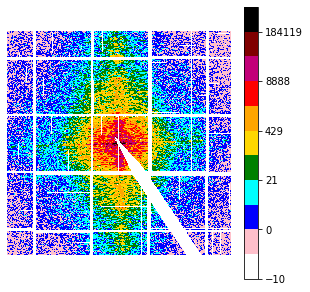

In [5]:
_measure_ = numpy.load( 'diff2D_2_2796_2796.npy')[0,:,:]


n   = _measure_.shape[0]
r   = 512
roi = _measure_[ n//2-r:n//2+r,n//2-r:n//2+r]


imshow( roi, (5,5))

array([-1.00000000e+01, -1.00000000e-01,  0.00000000e+00,  2.13338185e+00,
        4.55131812e+00,  9.70969946e+00,  2.07144966e+01,  4.41919311e+01,
        9.42782637e+01,  2.01131537e+02,  4.29090370e+02,  9.15413513e+02])

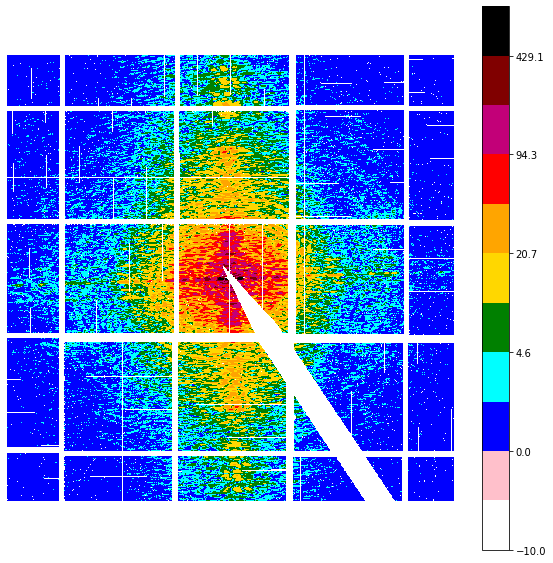

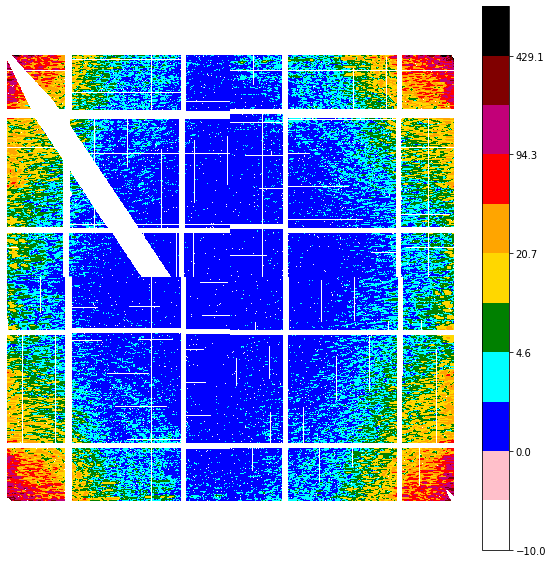

In [6]:
data = np.copy(roi)
data[data > 0] = np.sqrt(data[data > 0])

imshow(data,(10,10))

data = np.fft.fftshift(data)
# data[data < 0] = 0

imshow(data, (10,10))

array([-10. ,  -0.1,   0. ,   1. ,   1. ,   1. ,   1. ,   1. ,   1. ,
         1. ,   1. ,   1. ])

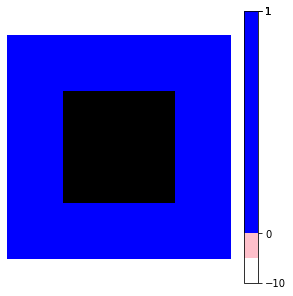

In [7]:
m = data.shape[0]
support = numpy.zeros( [m,m] )
_r = m//4
support[m//2-_r:m//2+_r, m//2-_r:m//2+_r] = 1

imshow(support, (5,5))

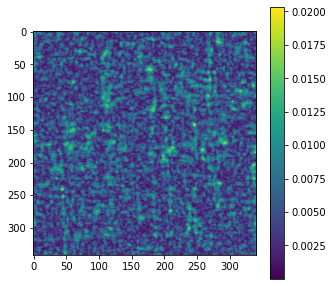

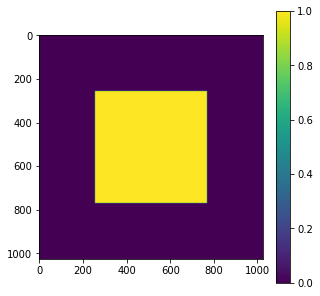

0 18.04580353780951


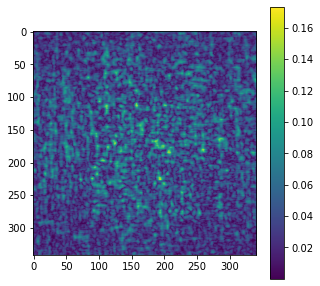

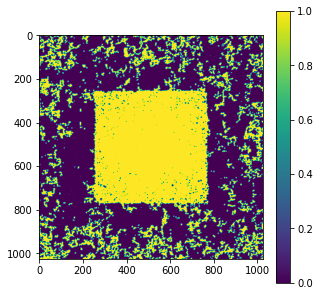

2000 0.8282498537248862


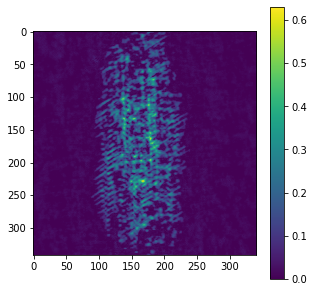

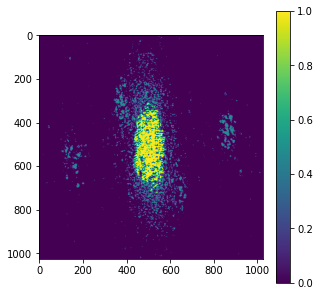

4000 11.626331598505482


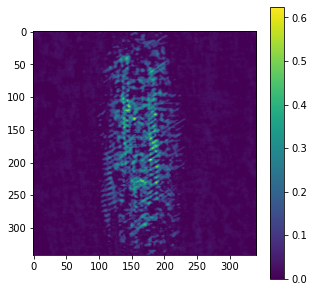

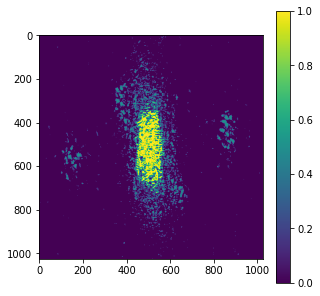

6000 12.734487377105696


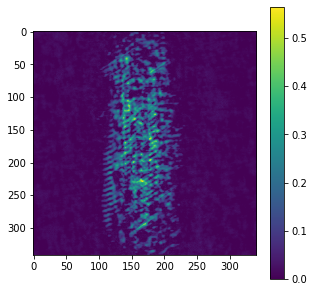

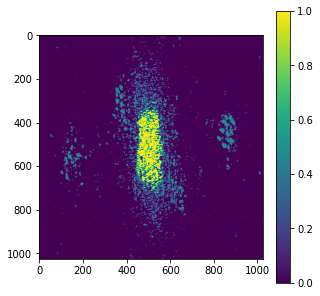

8000 12.177048120429998
Finished in 41.27 second(s)


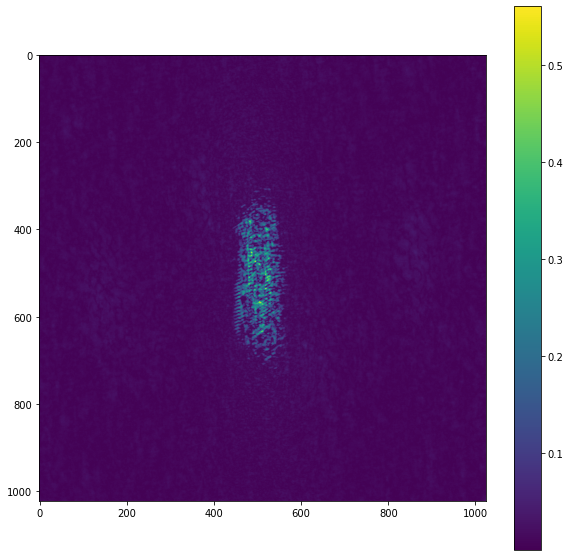

In [8]:
start = time.perf_counter()

m = data.shape[0]
support = numpy.zeros( [m,m] )
_r = m//4
support[m//2-_r:m//2+_r, m//2-_r:m//2+_r] = 1

threshold = 5
beta = 0.9

initial = np.fft.ifftn( data * numpy.exp(-1j * numpy.random.rand(data.shape[0],data.shape[1]) ) )

recon_init = HIO( initial, data, support, [10000, 10], beta, 0, threshold)


end = time.perf_counter()
print(f'Finished in {round(end-start, 2)} second(s)') 

plt.figure(figsize=(10,10))
plt.imshow( np.abs(recon_init))
plt.colorbar()

# Parallel Restauration

In [9]:
# HIO( initial, data, support, [10000, 10], beta, 0, threshold, iB)

exp = {}
exp['n'] = data.shape[0]
exp['data'] = data
exp['support'] = support
exp['recon_init'] = recon_init


In [10]:
def HIO_MultiProcess(exp):   
    start = time.perf_counter()

    init = exp['recon_init']* np.exp(-1j * np.random.rand(exp['n'],exp['n']) ) 
    
    recon = HIO(init, exp['data'], exp['support'],  [12000, 50], 0.95, 0, 6.0)
    
    end = time.perf_counter()
    print(f'Finished in {round(end-start, 2)} second(s)') 
    
    plt.figure(figsize=(10,10))
    plt.imshow( np.abs(recon))
    plt.colorbar()
    plt.show()
    
    return recon

0


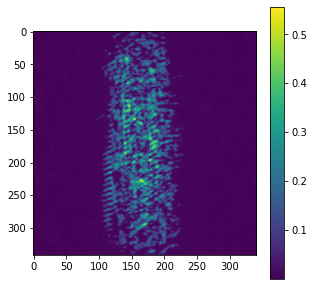

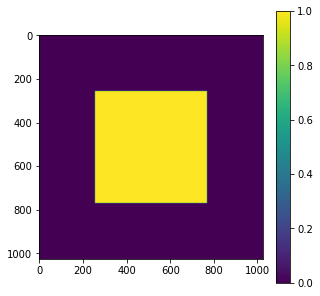

0 11.1714477248447


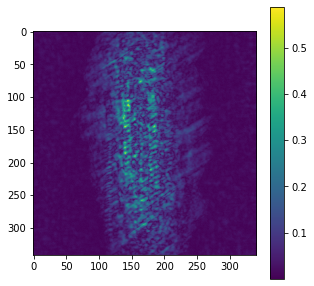

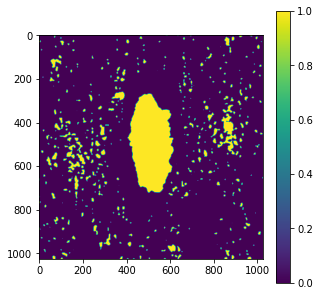

2000 5.720325648125665


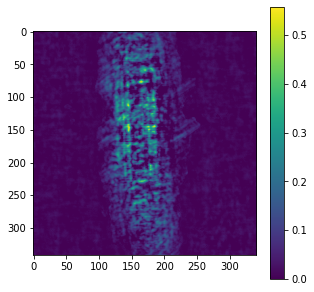

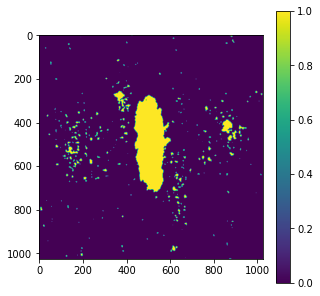

4000 13.640943182616159


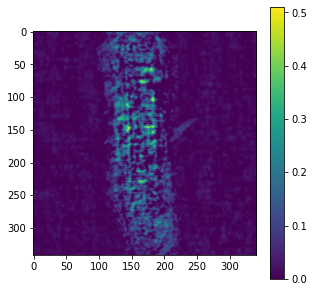

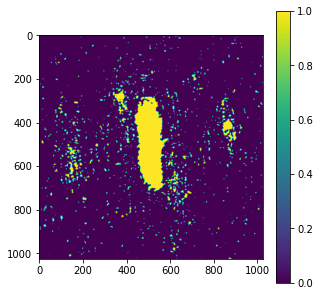

6000 15.537000258872876


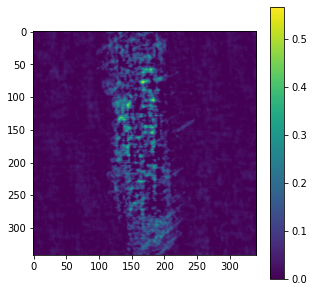

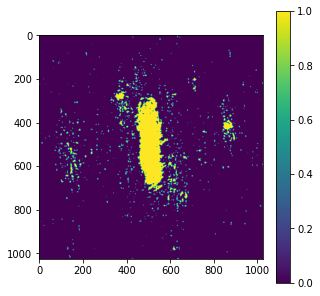

8000 16.29189541346749


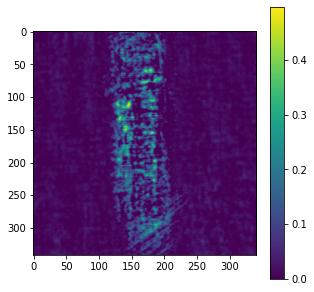

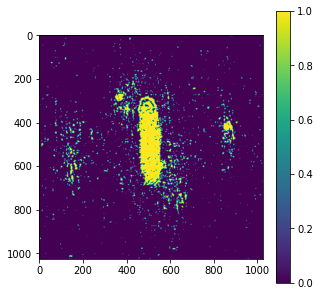

10000 16.999099427734553
Finished in 25.38 second(s)


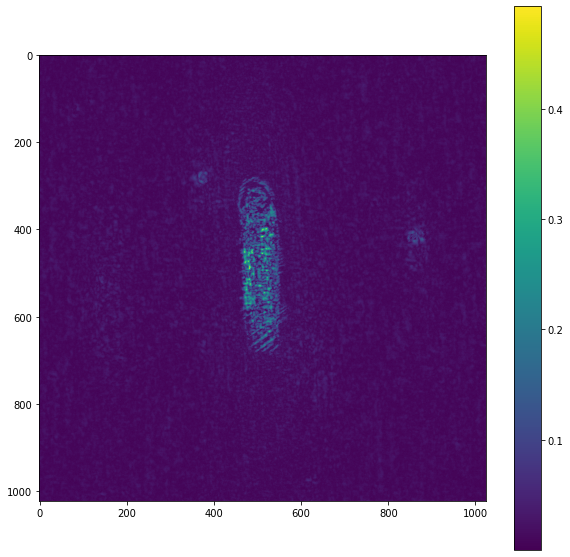

In [11]:
recon_ = []

for i in range(1):
    print(i)
    
    rec = HIO_MultiProcess(exp)
    
    recon_.append(rec)
    

In [12]:
mean = np.zeros((exp['n'], exp['n'])) + 1j* np.zeros((exp['n'], exp['n'])) 

for rec in recon_:
    mean += rec
    
mean = mean/100


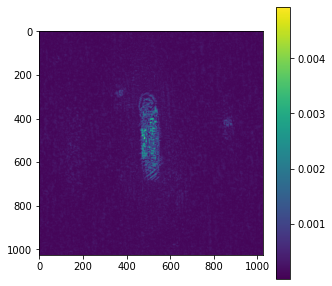

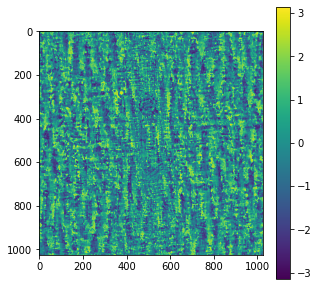

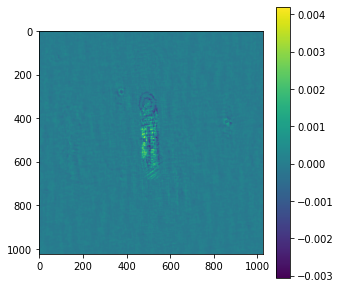

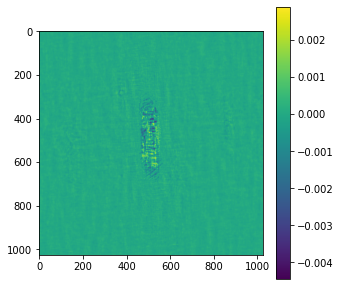

In [13]:
plt.figure(figsize=(5,5))
plt.imshow( np.abs(mean))
plt.colorbar()
plt.show()

plt.figure(figsize=(5,5))
plt.imshow( np.angle(mean))
plt.colorbar()
plt.show()

plt.figure(figsize=(5,5))
plt.imshow( mean.real)
plt.colorbar()
plt.show()

plt.figure(figsize=(5,5))
plt.imshow( mean.imag)
plt.colorbar()
plt.show()

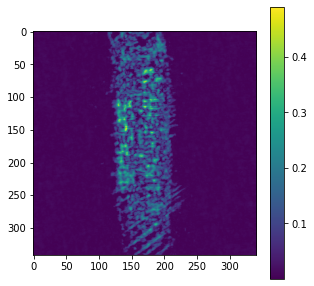

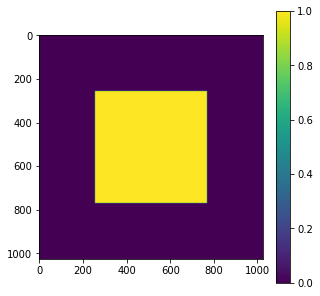

0 11.344059589543416


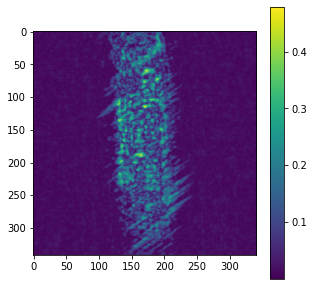

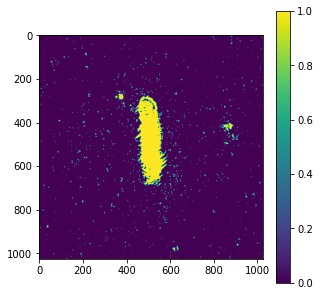

2000 5.709844874490485


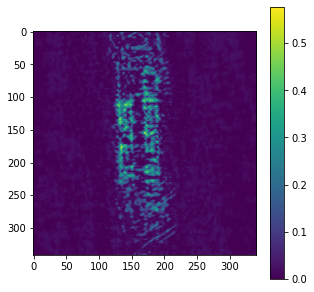

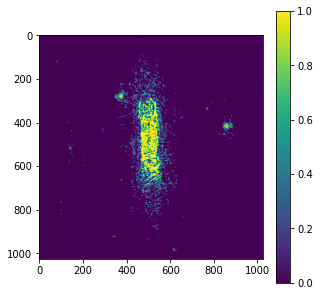

4000 13.739839783539296


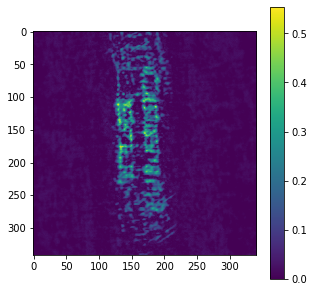

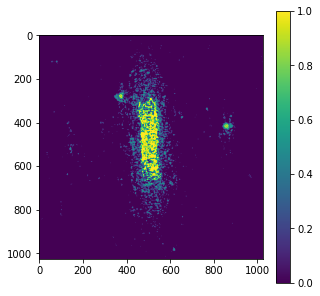

6000 13.536317117811494


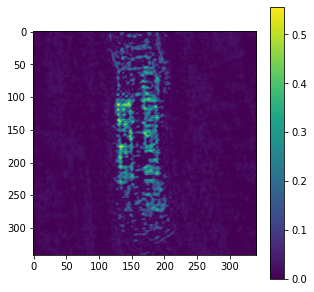

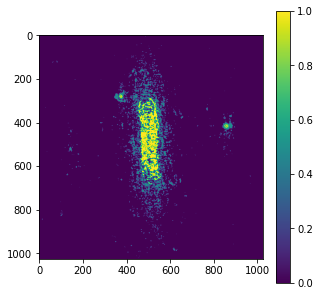

8000 13.71624292090356
Finished in 41.21 second(s)


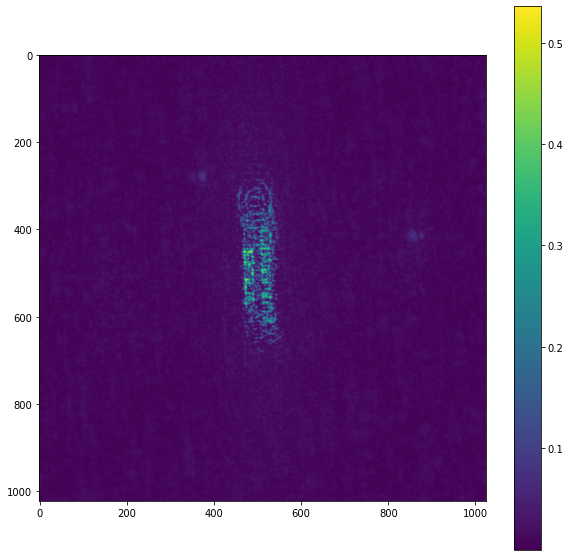

In [14]:
start = time.perf_counter()

m = data.shape[0]
support = numpy.zeros( [m,m] )
_r = m//4
support[m//2-_r:m//2+_r, m//2-_r:m//2+_r] = 1

threshold = 6
beta = 0.9

# initial = np.fft.ifftn( data * numpy.exp(-1j * numpy.random.rand(data.shape[0],data.shape[1]) ) )

recon_init = HIO( rec, data, support, [10000, 10], beta, 0, threshold)


end = time.perf_counter()
print(f'Finished in {round(end-start, 2)} second(s)') 

plt.figure(figsize=(10,10))
plt.imshow( np.abs(recon_init))
plt.colorbar()

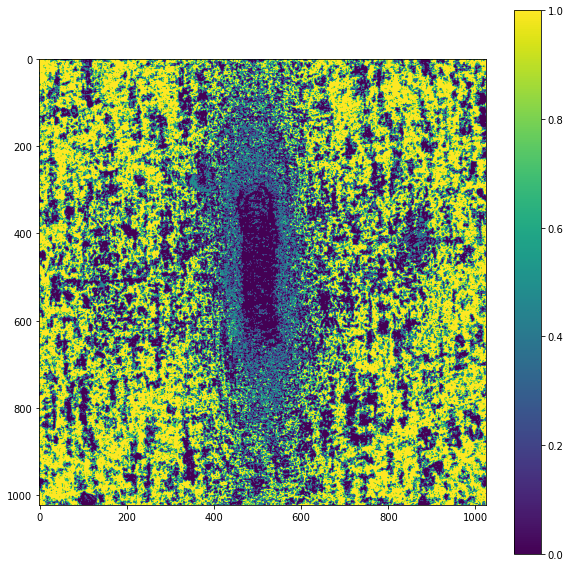

In [15]:
supp = np.zeros((m,m))
supp[np.abs(recon_init) < 0.01] =1

plt.figure(figsize=(10,10))
plt.imshow( supp)
plt.colorbar()

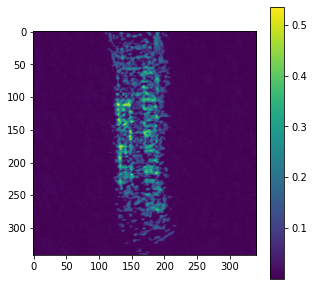

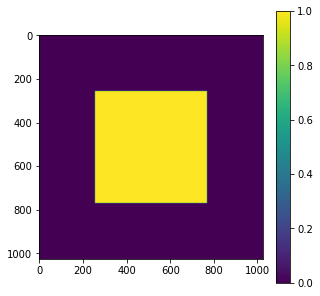

0 9.950293098564128


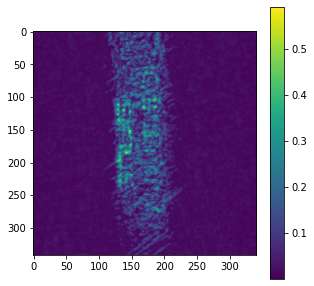

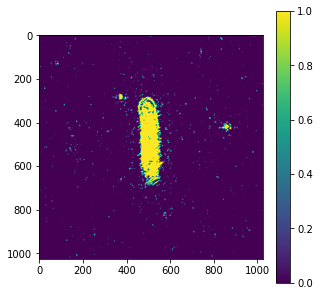

2000 5.940978480053594


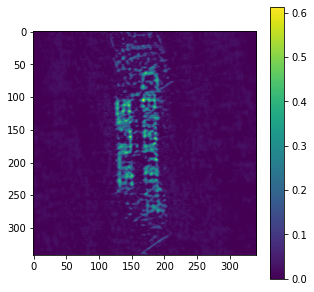

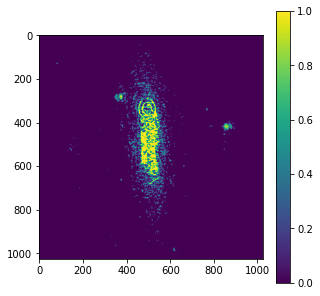

4000 14.293963407235172


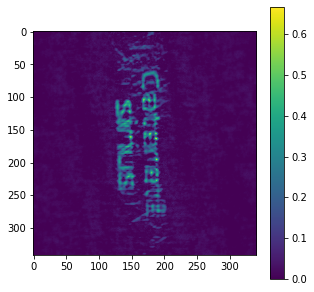

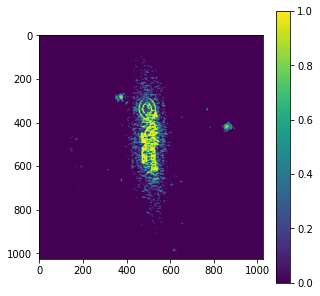

6000 15.182409603413577


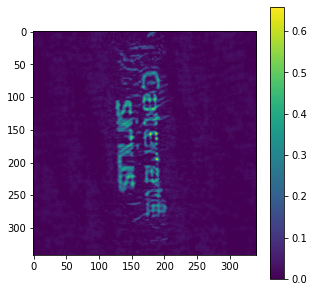

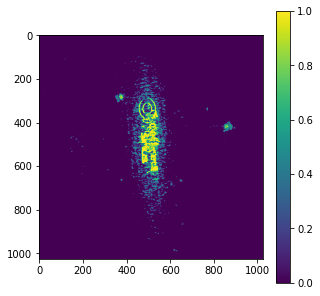

8000 15.390371584234698


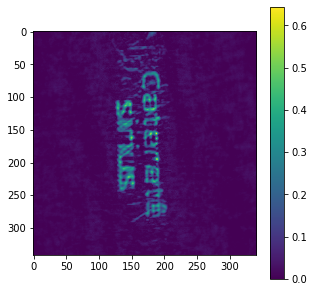

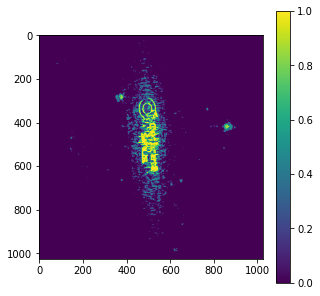

10000 15.170053498655838


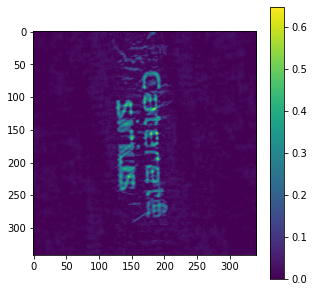

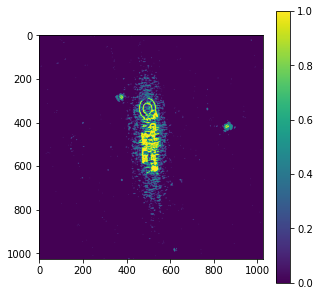

12000 15.275431490801383


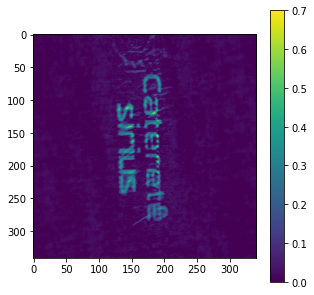

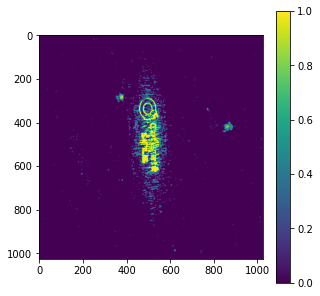

14000 16.066383505372247


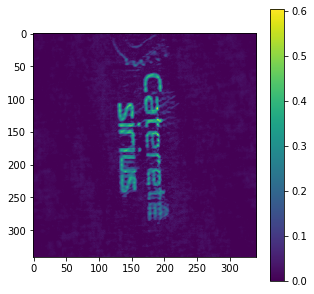

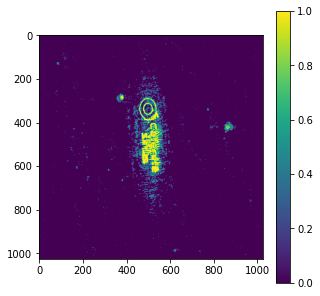

16000 15.496596673557583


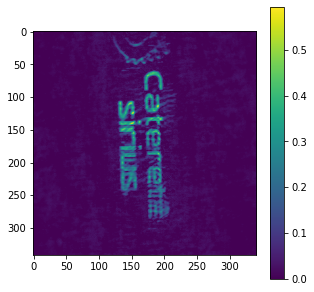

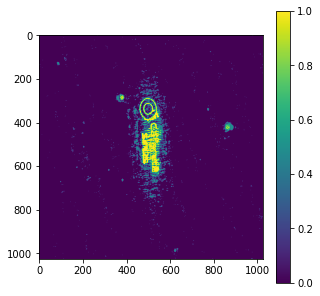

18000 15.253429174180209
Finished in 86.37 second(s)


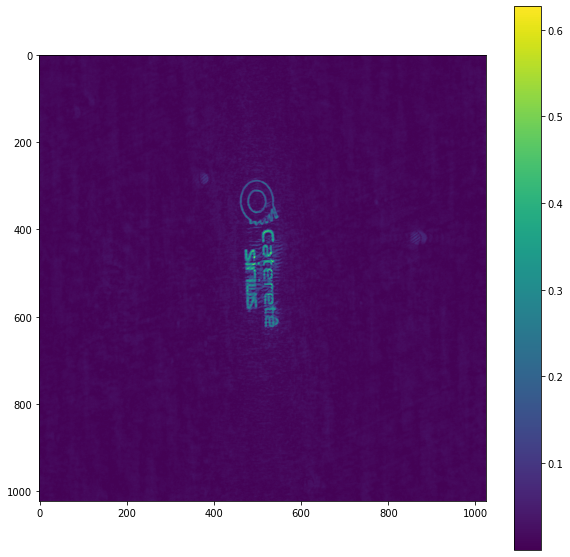

In [16]:
start = time.perf_counter()

m = data.shape[0]
support = numpy.zeros( [m,m] )
_r = m//4
support[m//2-_r:m//2+_r, m//2-_r:m//2+_r] = 1

threshold = 6
beta = 0.95

recon_init = HIO( recon_init, data, support, [20000, 10], beta, 0, threshold)


end = time.perf_counter()
print(f'Finished in {round(end-start, 2)} second(s)') 

plt.figure(figsize=(10,10))
plt.imshow( np.abs(recon_init))
plt.colorbar()

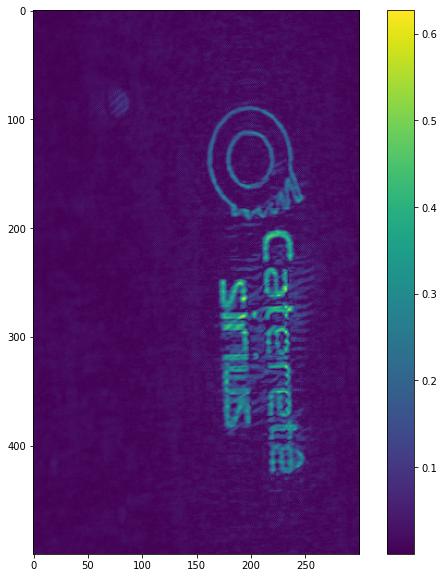

In [17]:
teste = recon_init[200:700, 300:600]

plt.figure(figsize=(10,10))
plt.imshow( np.abs(teste))
plt.colorbar()

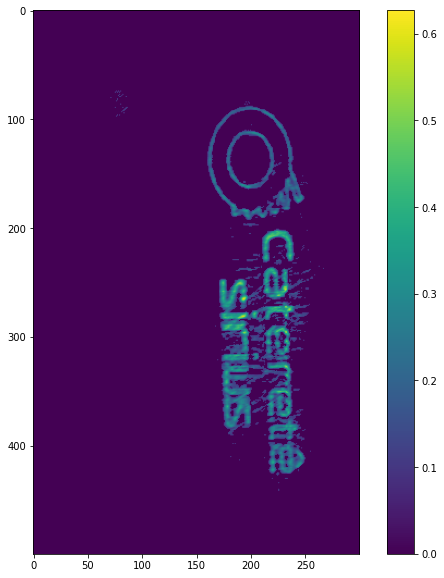

In [18]:
teste[np.abs(teste) < 0.1] = 0.0 + 1j*0.0


plt.figure(figsize=(10,10))
plt.imshow( np.abs(teste))
plt.colorbar()

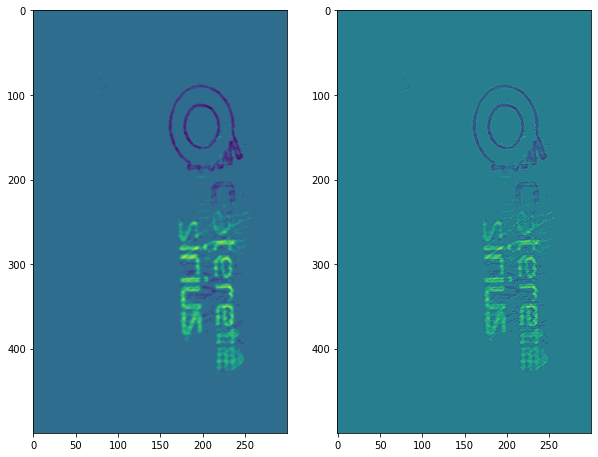

In [19]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


import scipy.signal
from scipy.signal import convolve2d

image = teste.real
img_array = np.array(image).astype('float')


def RGB_convolve(image,kern):
    image[:,:]=convolve2d(image[:,:],kern, 'same')
    return image

KERNEL_sharpen = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]) / 255
im_filtered = RGB_convolve(img_array,KERNEL_sharpen)


plt.figure( figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow( image )
plt.subplot(1,2,2)
plt.imshow( im_filtered )